In [1]:
%matplotlib inline

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import OneHotEncoder

# Import the file and preprocess it

In [34]:
data = pd.read_csv('./ML case/data.csv', parse_dates=['date_in'], dtype={'agency_rating': np.int64})

`agancy_rating`, the only ordinal variable will be treated as a numeric one for the sake of this classification.

In [35]:
data['year'] = data['date_in'].dt.year
data['month'] = data['date_in'].dt.month 
data['weekday'] = data['date_in'].dt.weekday

In [36]:
data.shape

(85195, 23)

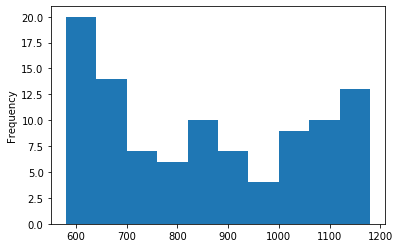

In [37]:
data['house_pk'].value_counts().plot(kind='hist')

In [9]:
data[['agency_id', 'agency_rating']].pivot_table(index='agency_id', columns='agency_rating', aggfunc=len)

agency_rating,2,3,4,5
agency_id,,,,
90,NaN,23554.0,3042.0,1969.0
121,652.0,5660.0,11310.0,7476.0
130,NaN,3121.0,5624.0,2880.0
160,NaN,6651.0,6729.0,6527.0


In [38]:
data = pd.concat([data, pd.get_dummies(data, columns=['agency_id'], drop_first=True)], sort=False)

In [39]:
data.columns

Index(['house_pk', 'agency_id', 'date_in', 'price', 'dis_water_real',
       'dis_shopping', 'no_bedrooms', 'max_persons', 'house_size', 'land_size',
       'build_year', 'renovation_year', 'apartment', 'indoor_pool', 'spa',
       'internet', 'pets_allowed', 'water_view', 'fire_stove', 'agency_rating',
       'year', 'month', 'weekday', 'agency_id_121', 'agency_id_130',
       'agency_id_160'],
      dtype='object')

# Exploratory data anlysis (EDA)

First, we will discover the relationship between the target variable and the features.

### Plot y's (price's) distribution

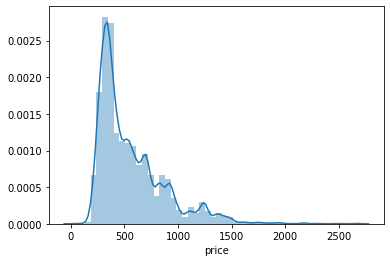

In [24]:
sns.distplot(data['price'])

As the distribution of price is highly non-normal, it will be more reasonable to work with log-normalized data.

In [40]:
data['price'] = np.log10(data['price'])

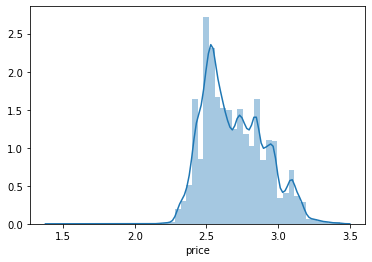

In [27]:
sns.distplot(data['price'])

### Categorical variables

It pays off to plot the distribution with respect to the year even if it cannot be used as an explanatory variable.

In [47]:
cat_variables = ['agency_id', 'apartment', 'indoor_pool', 'spa', 'internet', 'pets_allowed', 'water_view', 'fire_stove', 'agency_rating', 'year', 
                 'month', 'weekday']

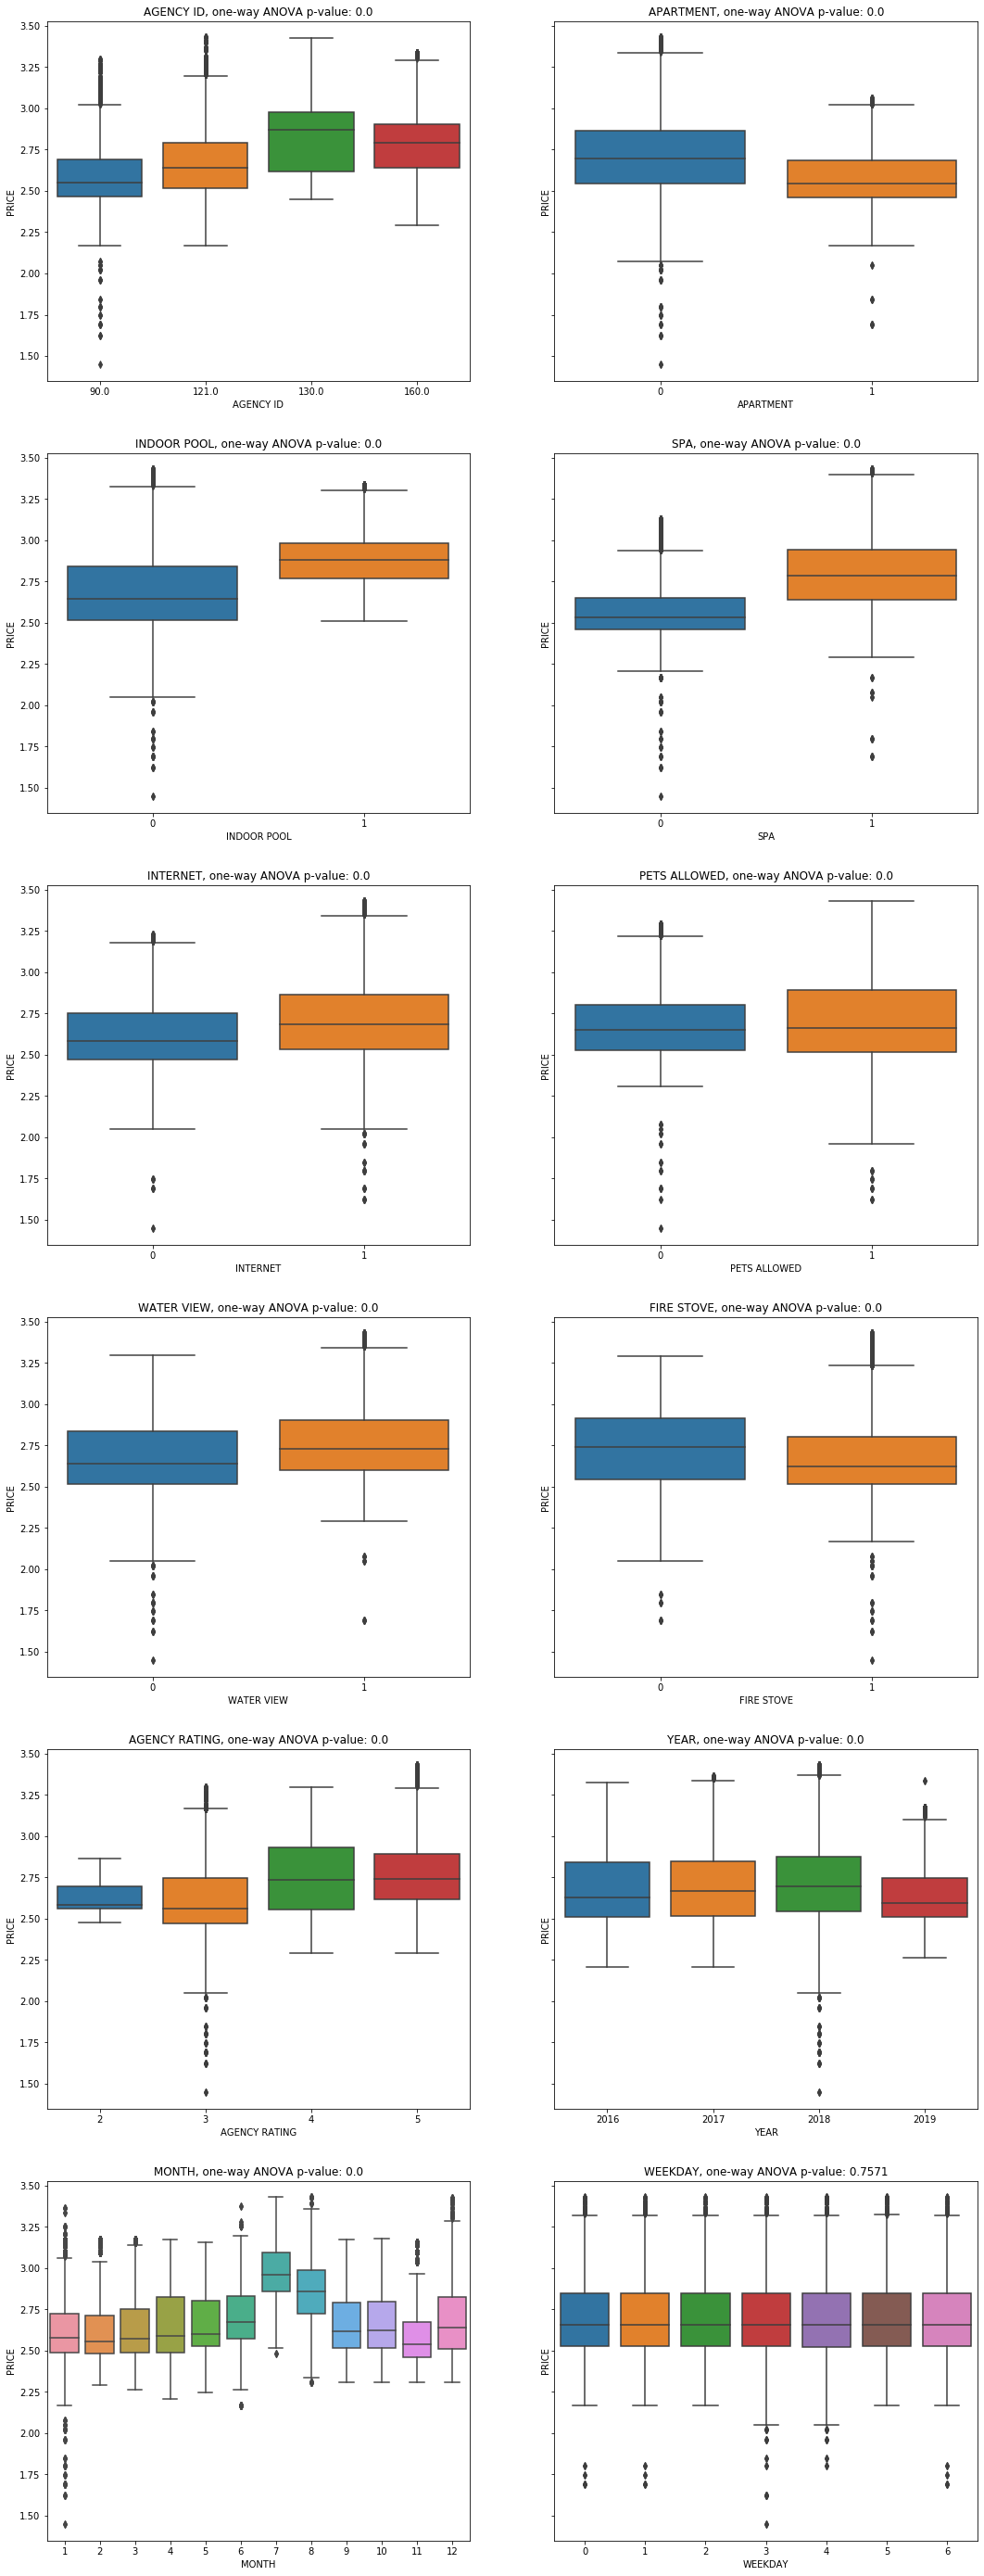

In [42]:
n_rows = len(cat_variables) // 2 + len(cat_variables) % 2
n_cols = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, figsize=(18, 50))

for i, var in enumerate(cat_variables):
    var_name = var.upper().replace('_', ' ')
    sns.boxplot(data=data, x=var, y='price', ax=ax[i // 2, i % 2])
    s, p = stats.f_oneway(*[np.log10(data['price'].loc[x[1][var].index].values) for x in data[var].to_frame().groupby(var, squeeze=True)])
    ax[i // 2, i % 2].set_title(f'{var_name}, one-way ANOVA p-value: {np.round(p, 4)}')
    ax[i // 2, i % 2].set_xlabel(var_name)
    ax[i // 2, i % 2].set_ylabel('PRICE')
    
# remove unused axes
if i+1 != n_rows*n_cols:
    ax.flat[-1].set_visible(False)

### Continuous variables

In [48]:
con_variables = ['dis_water_real', 'dis_shopping', 'no_bedrooms', 'max_persons', 'house_size', 'land_size', 'build_year', 'renovation_year']

Apparently, `no_bedrooms` could be treated as a categorical variable due to the low number of values it takes.

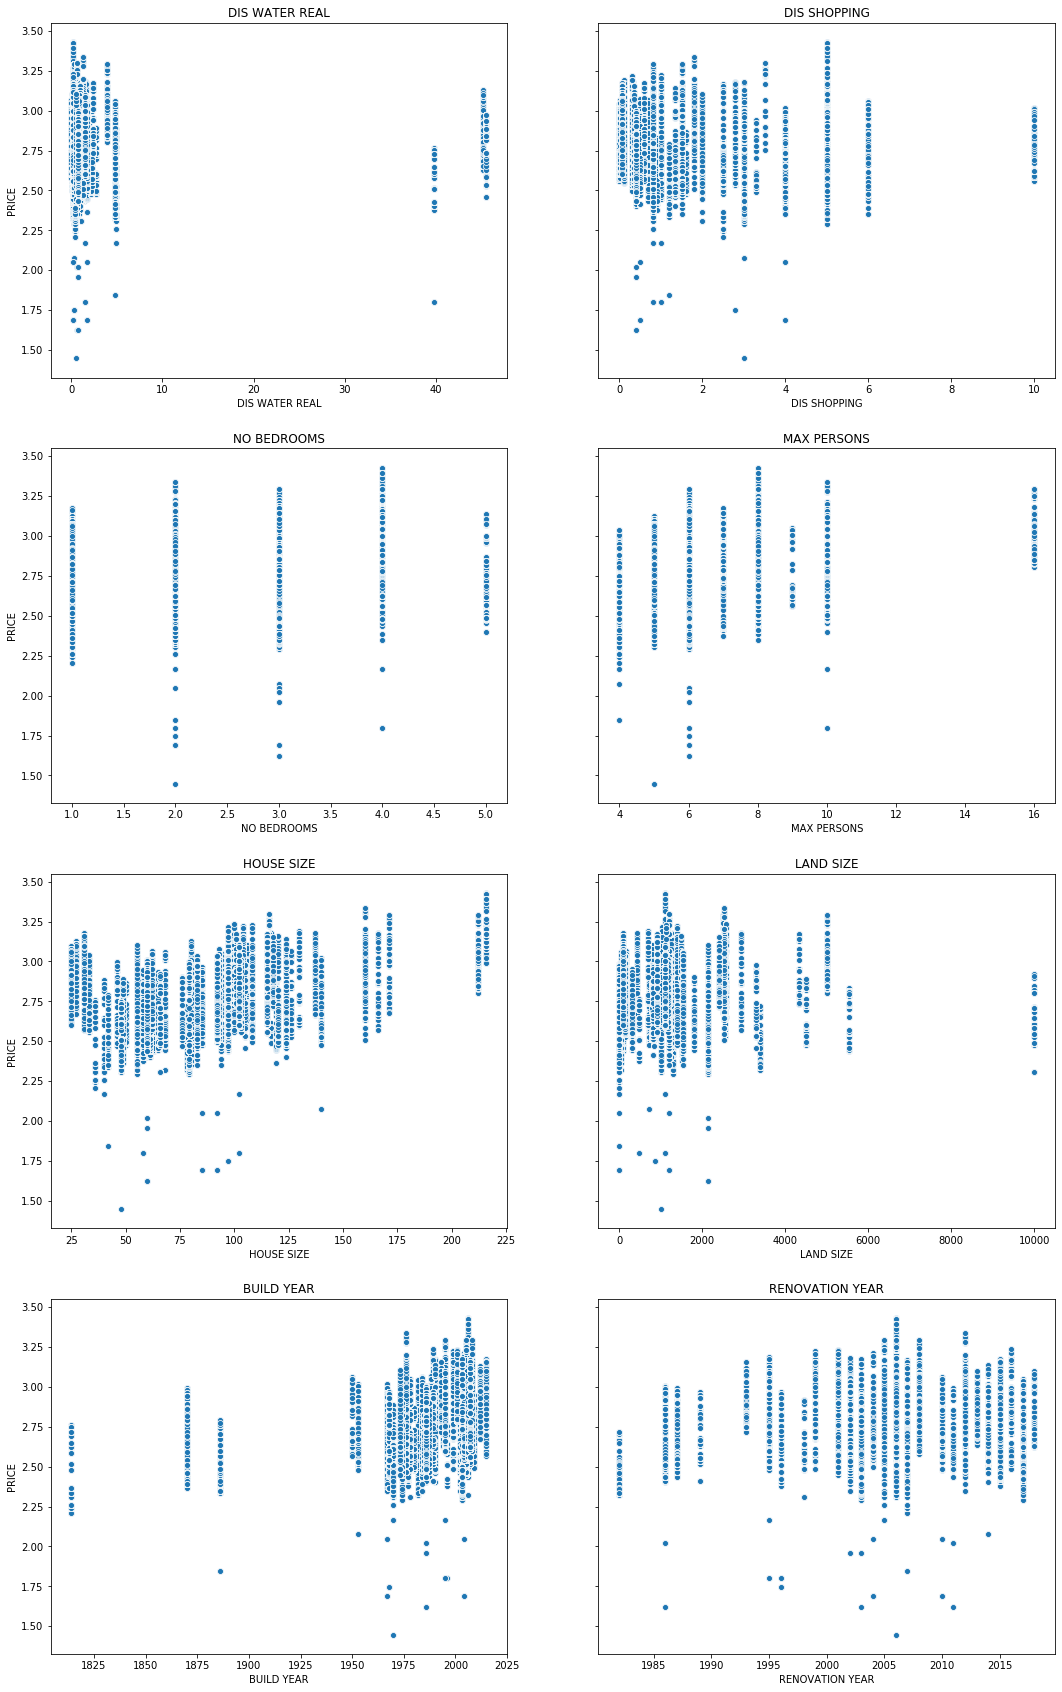

In [44]:
n_rows = len(con_variables) // 2 + len(con_variables) % 2
n_cols = 2

fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, figsize=(18, 30))

for i, var in enumerate(con_variables):
    var_name = var.upper().replace('_', ' ')
    sns.scatterplot(data=data, x=var, y='price', ax=ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_title(var_name)
    ax[i // 2, i % 2].set_xlabel(var_name)
    ax[i // 2, i % 2].set_ylabel('PRICE')
    
# remove unused axes
if i+1 != n_rows*n_cols:
    ax.flat[-1].set_visible(False)

### Correlation between features

In [49]:
all_variables = cat_variables + con_variables

# TODO: add rectangles with indication on continuous / discrete variable

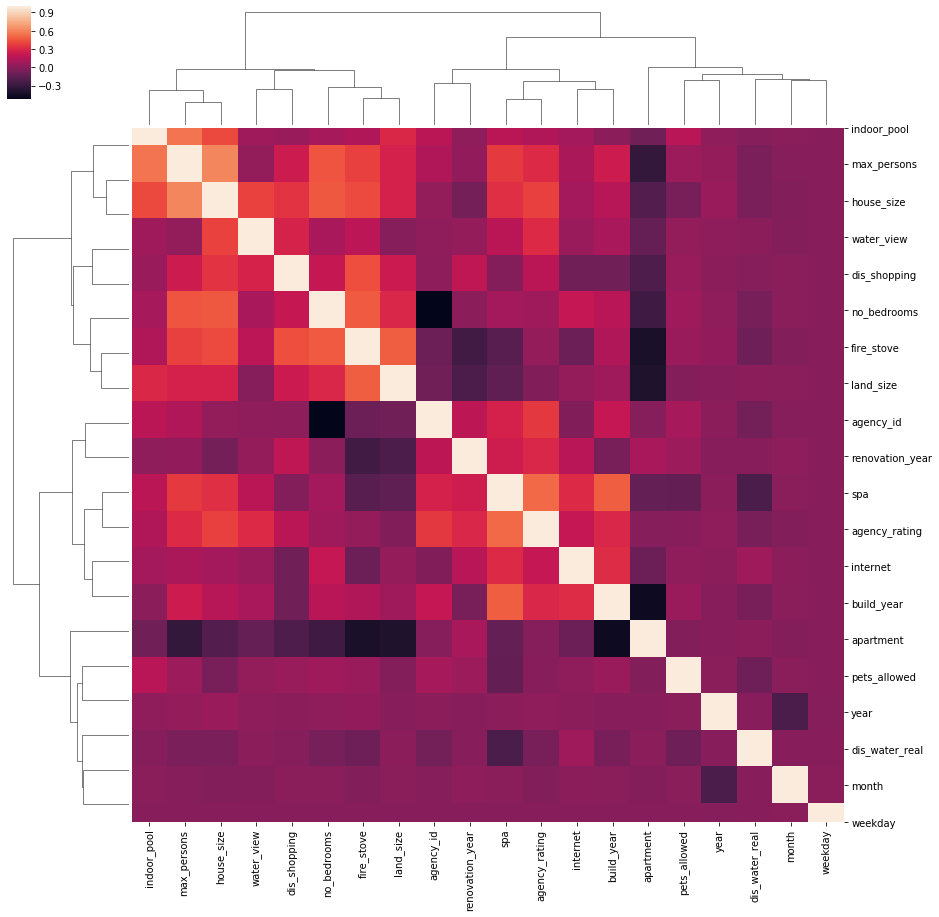

In [56]:
sns.clustermap(data[all_variables].corr(method='pearson'), method='ward', figsize=(15, 15), row_cluster=True, col_cluster=True)

# Regression model, solely on tabular data, to predict price